## Example: Horizontal line with Von Karman spectrum

In [9]:
import numpy as np 
import os
import matplotlib.pyplot as plt
from yawisi.parameters import SimulationParameters
from yawisi.wind_field import WindField
from yawisi.display import display_points
from yawisi.spectrum import Spectrum
from yawisi.locations import Locations, Grid
# from yawisi.kernels import CoherenceKernel
from yawisi.wind import Wind
from tqdm import tqdm

### reading parameters

In [10]:
filename =  "config.ini"
params = SimulationParameters(filename)

In [4]:
print(params)

Number of Samples Initialized @ 3000
Sample Time Initialized @ 0.25
Wind Mean Speed Initialized @ 20
turbulence length scale for longitudinal component @ 170.0
turbulence length scale for transversal component @ 100.0
turbulence length scale for vertical component @ 35.0
Std of wind fluctuation of the longitudinal component @ 2.6
std of wind fluctuation of the transversal component @  2.2
std of wind fluctuation of the vertical component @ 1.56
PL Exp Law initialized  @ 0.15
Reference Height @ 60.0
Ymin @ 0.0
Ymax @ 100.0
Zmin @ 60.0
Zmax @ 60.0



### Displaying locations

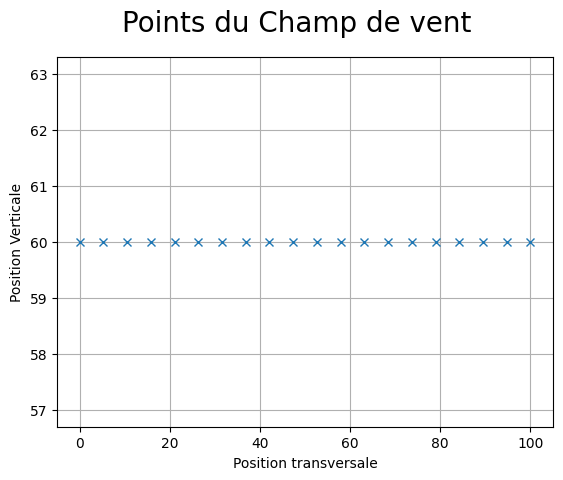

In [11]:
grid = Locations.create("grid", ny=(params.ny), nz=(params.nz), ymin=(params.ymin), ymax=(params.ymax), zmin=(params.zmin), zmax=(params.zmax))
display_points(grid)

### Generating the wind field 

In [6]:
wind_field = WindField(params)
wind_field.compute()

_______________Wind Field Display___________________________________
Simulation Parameters:
Samples Numbers: 3000
SampleTime: 0.25
WindField Points:
Point 0 : Y=0, Z=60
Wind Values have been initialized


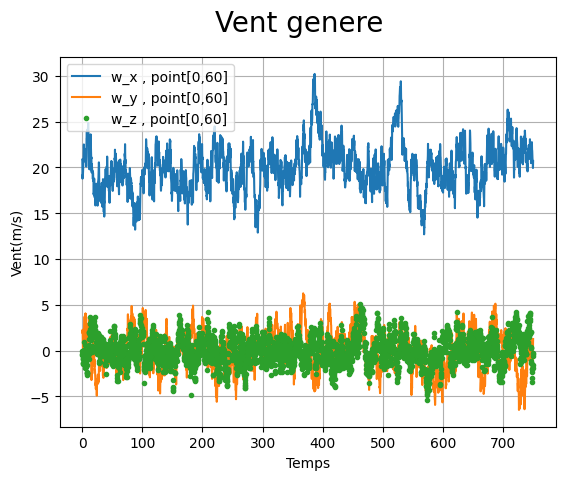

________________End OF DISPLAY____________________________________


In [7]:
from yawisi.display import  display_field
pts = [
            (0, 60)
        ]
wind_field.locations = Locations.create("points")
wind_field.locations.add_points(pts)
display_field(wind_field=wind_field)

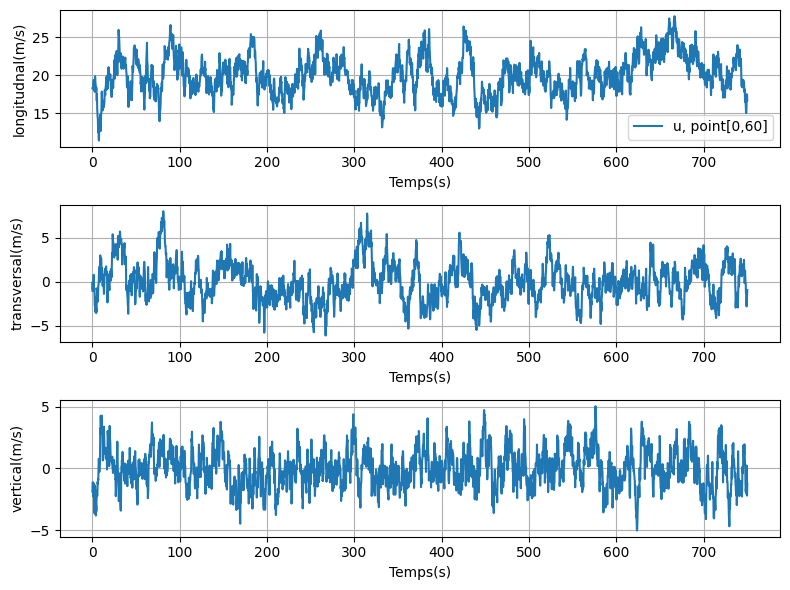

In [13]:
fig = plt.figure(figsize=(8, 6))

# Create subplots for each wind component
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
t_tot = wind_field.params.n_samples * wind_field.params.sample_time
Time = np.arange(0, t_tot, wind_field.params.sample_time)

i = 0
for i, pt in enumerate(wind_field.locations.points):
    wind: Wind = wind_field.winds[i]

    # Plot w_x in the first subplot (ax1)
    ax1.plot(Time, wind.wind_values[:, 0], label="u, point[%s,%s]" % (pt[0], pt[1]))

    # Plot w_y in the second subplot (ax2)
    ax2.plot(Time, wind.wind_values[:, 1], label="v, point[%s,%s]" % (pt[0], pt[1]))

    # Plot w_z in the third subplot (ax3)
    ax3.plot(Time, wind.wind_values[:, 2], label="w, point[%s,%s]" % (pt[0], pt[1]))

# Set labels and title for each subplot
ax1.set_ylabel("longitudnal(m/s)")
ax1.set_xlabel("Temps(s)")
ax1.legend()
ax1.grid()

ax2.set_ylabel("transversal(m/s)")
ax2.set_xlabel("Temps(s)")
ax2.grid()

ax3.set_ylabel("vertical(m/s)")
ax3.set_xlabel("Temps(s)")
ax3.grid()

plt.tight_layout()
plt.show()

### Standard deviation

In [42]:
std_u = []
std_v = []
std_w = []
for i, pt in enumerate(wind_field.locations.points):
    wind_temp: Wind = wind_field.winds[i]
    std_u.append(np.std(wind_temp.wind_values[:, 0]))
    std_v.append(np.std(wind_temp.wind_values[:, 1]))
    std_w.append(np.std(wind_temp.wind_values[:, 2]))
std_u = np.array(std_u)
std_v = np.array(std_v)
std_w = np.array(std_w)


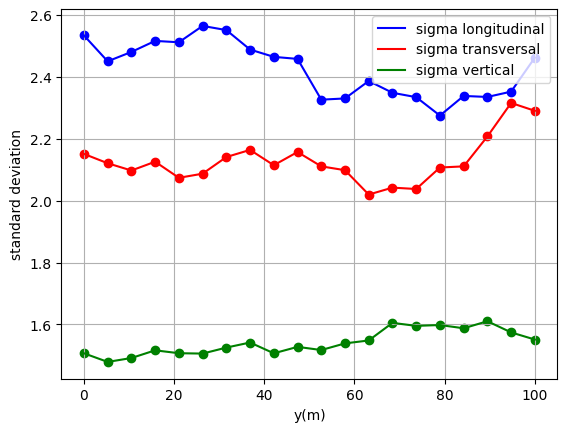

In [43]:
y = np.linspace (0, 100, 20)
plt.figure()
plt.plot(y, std_u, color='b', label='sigma longitudinal')
plt.scatter(y, std_u, color='b')
plt.plot(y, std_v, color='r', label='sigma transversal')
plt.scatter(y, std_v, color='r')
plt.plot(y, std_w, color='g', label='sigma vertical')
plt.scatter(y, std_w, color='g')
plt.grid(True)
plt.xlabel("y(m)")
plt.ylabel("standard deviation")
plt.legend(loc="upper right")
plt.show()

### Turbulence intensity

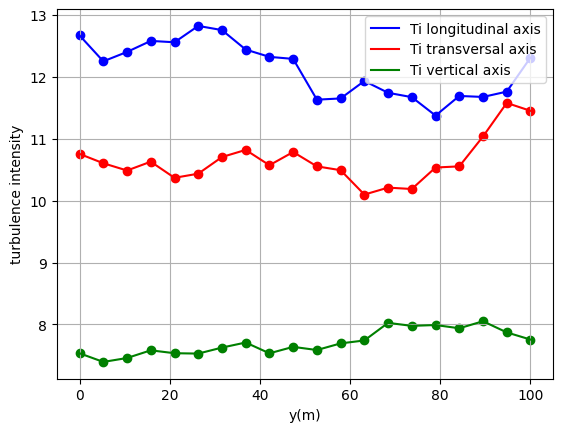

In [44]:
U_target = 20
Iu = std_u / U_target * 100
Iv =  std_v / U_target * 100
Iw = std_w / U_target * 100 
plt.figure()
plt.plot(y, Iu, color='b', label='Ti longitudinal axis')
plt.scatter(y, Iu, color='b')
plt.plot(y, Iv, color='r', label='Ti transversal axis')
plt.scatter(y, Iv, color='r')
plt.plot(y, Iw, color='g', label='Ti vertical axis')
plt.scatter(y, Iw, color='g')
plt.grid(True)
plt.xlabel("y(m)")
plt.ylabel("turbulence intensity")
plt.legend(loc="upper right")
plt.show()

### Comparison with Von Karman

In [48]:
from yawisi.spectrum import Spectrum
spectrum = Spectrum(wind_field.params)
Sf = spectrum.compute(wind_field.locations)
freq = spectrum.freq
Sf_u = Sf[:, :, 0]
Sf_v = Sf[:, :, 1]
Sf_w = Sf[:, :, 2]
Sf_u_mean = np.mean(Sf_u, axis=0)
Sf_v_mean = np.mean(Sf_v, axis=0)
Sf_w_mean = np.mean(Sf_w, axis=0)
Sf_u_mean.shape

(1500,)

In [14]:
from scipy.signal import welch
t_tot = wind_field.params.n_samples * wind_field.params.sample_time
Time = np.arange(0, t_tot, wind_field.params.sample_time)
Nblock = 6
tmax = Time[-1]
dt = np.median(np.diff(Time))
fs = 1/dt
N = wind_field.params.n_samples
Ncoh = int(round(N/Nblock))
overlap = Ncoh//2

SU = np.zeros((len(wind_field.locations.points), Ncoh//2))
for i, pt in enumerate(wind_field.locations.points):
    wind: Wind = wind_field.winds[i]
    F, Spec = welch( wind.wind_values[:, 0], fs=fs, nperseg=Ncoh, noverlap=Ncoh//2)
    SU[i, :] = Spec[1:]
SU_mean = np.mean(SU, axis=0)

SV = np.zeros((len(wind_field.locations.points), Ncoh//2))
for i, pt in enumerate(wind_field.locations.points):
    wind: Wind = wind_field.winds[i]
    F, Spec = welch( wind.wind_values[:, 1], fs=fs, nperseg=Ncoh, noverlap=Ncoh//2)
    SV[i, :] = Spec[1:]
SV_mean = np.mean(SV, axis=0)

SW = np.zeros((len(wind_field.locations.points), Ncoh//2))
for i, pt in enumerate(wind_field.locations.points):
    wind: Wind = wind_field.winds[i]
    F, Spec = welch( wind.wind_values[:, 2], fs=fs, nperseg=Ncoh, noverlap=Ncoh//2)
    SW[i, :] = Spec[1:]
SW_mean = np.mean(SW, axis=0)


In [58]:
freq[-1]

2.0

In [56]:
F[-1]

2.0

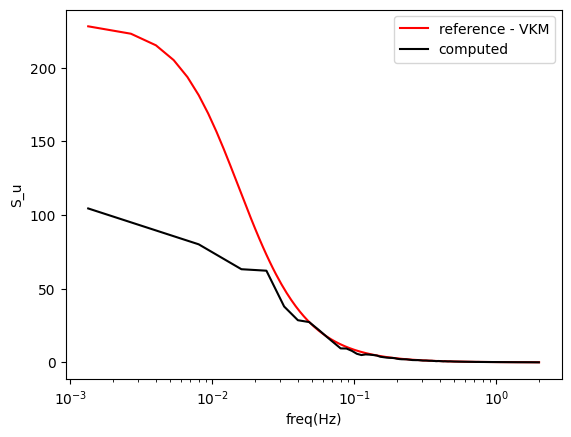

In [62]:
plt.figure()
plt.plot(freq, (Sf_u_mean), color='r', label="reference - VKM")
plt.plot(F[0:250], (SU_mean[:250]), color='k', label="computed")
plt.xlabel("freq(Hz)")
plt.ylabel("S_u")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

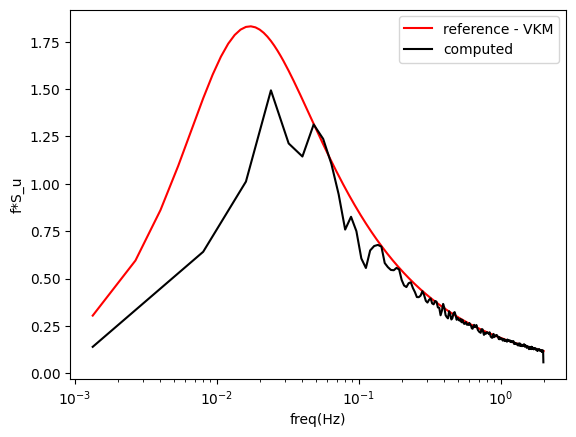

In [53]:
plt.figure()
plt.plot(freq, (freq*Sf_u_mean.T), color='r', label="reference - VKM")
# plt.plot(F[:-1], (F[:-1]*SU_mean.T), color='k', label="computed")
plt.plot(F[0:250], (F[0:250]*SU_mean[:250].T), color='k', label="computed")
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_u")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

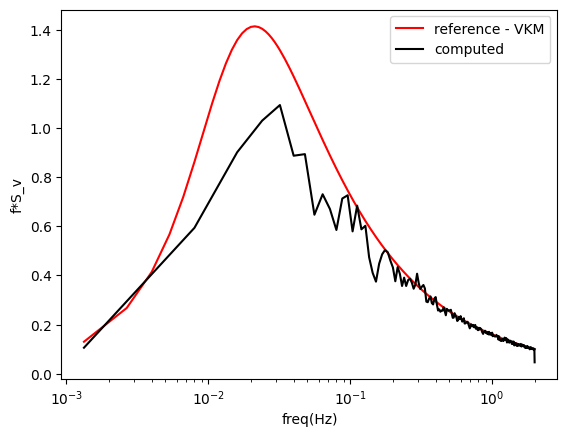

In [60]:
plt.figure()
plt.plot(freq, (freq*Sf_v_mean.T), color='r', label="reference - VKM")
plt.plot(F[:250], (F[:250]*SV_mean.T), color='k', label="computed")
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_v")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

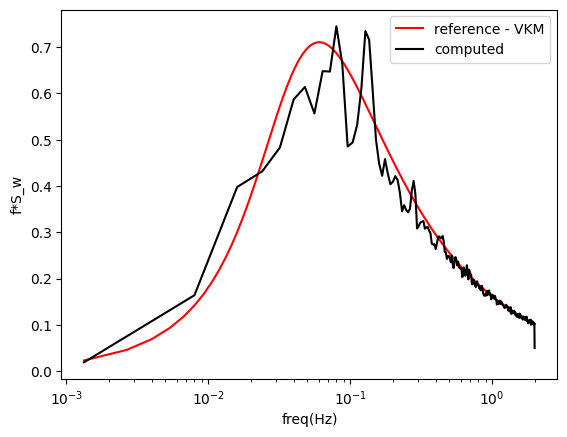

In [65]:
plt.figure()
plt.plot(freq, (freq*Sf_w_mean.T), color='r', label="reference - VKM")
plt.plot(F[:250], (F[:250]*SW_mean.T), color='k', label="computed")
# plt.plot(f,su, color='r')
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_w")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

### Spatial coherence verification 

In [66]:
from scipy.signal import csd

def coherence(X, Y, Fs=2, WINDOW='hann', NPERSEG=None, NOVERLAP=None, NFFT=None):
    # X = detrend(X, type='constant')
    # Y = detrend(Y, type='constant') 

    #Get cross spectrum 
    freq, pxy = csd(X, Y, fs=Fs, window=WINDOW, nperseg=NPERSEG, noverlap=NPERSEG//2, nfft=NFFT)

    # Get single point spectrum
    _, pxx = csd(X, X, fs=Fs, window=WINDOW, nperseg=NPERSEG, noverlap=NPERSEG//2,  nfft=NFFT)
    _, pyy = csd(Y, Y, fs=Fs, window=WINDOW, nperseg=NPERSEG, noverlap=NPERSEG//2,  nfft=NFFT)

    # Normalize the cross spectrum
    cocoh = np.real(pxy / np.sqrt(pxx * pyy))  # co-coherence
    Quad = np.imag(pxy / np.sqrt(pxx * pyy))  # quad-coherence

    return cocoh, Quad, freq

In [67]:
from scipy.signal import welch
t_tot = wind_field.params.n_samples * wind_field.params.sample_time
Time = np.arange(0, t_tot, wind_field.params.sample_time)
Nblock = 6
tmax = Time[-1]
dt = np.median(np.diff(Time))
fs = 1/dt
N = wind_field.params.n_samples
Ncoh = int(round(N/Nblock))
overlap = Ncoh//2

cocoh_temp = np.zeros((len(wind_field.locations.points), len(wind_field.locations.points), Ncoh//2))
for i, pt in enumerate(wind_field.locations.points):
    for j, pt2 in enumerate(wind_field.locations.points):
        wind1: Wind = wind_field.winds[i]
        wind2: Wind = wind_field.winds[j]
        coh, _, freq = coherence(wind1.wind_values[:,0], wind2.wind_values[:,0], Fs=fs, NPERSEG=Ncoh, NOVERLAP=overlap, NFFT=Ncoh)
        cocoh_temp[i, j :] = coh[:Ncoh//2] 
    

In [69]:
y = grid.get_distance_matrix()
uniqueDist = np.unique(np.round(y.flatten() * 100) / 100)
distTarget = [10,20,40,60]
# freq = np.linspace(0.003, 1, 1000)

## Averaging coherence 
y_size = len(wind_field.locations.points)
cocoh = np.reshape(cocoh_temp, (y_size*y_size, -1))
meanCoCoh = np.zeros((len(np.unique(uniqueDist)), cocoh.shape[1]))

for ii, dist in enumerate(np.unique(uniqueDist)):
    ind = np.where(np.round(y.flatten() * 100) / 100 == dist)[0]
    print(ii, dist, cocoh[ind, :].shape)
    meanCoCoh[ii, :] = np.nanmean(cocoh[ind, :], axis=0)
print(meanCoCoh.shape)

0 0.0 (20, 250)
1 5.26 (38, 250)
2 10.53 (36, 250)
3 15.79 (34, 250)
4 21.05 (32, 250)
5 26.32 (30, 250)
6 31.58 (28, 250)
7 36.84 (26, 250)
8 42.11 (24, 250)
9 47.37 (22, 250)
10 52.63 (20, 250)
11 57.89 (18, 250)
12 63.16 (16, 250)
13 68.42 (14, 250)
14 73.68 (12, 250)
15 78.95 (10, 250)
16 84.21 (8, 250)
17 89.47 (6, 250)
18 94.74 (4, 250)
19 100.0 (2, 250)
(20, 250)


In [26]:
ts = wind_field.get_uvwt()
u = ts[0] 

## parameters for numerical estimation of the co-coherence. 
Nblock = 6
Nsamples, N = u.shape[1], len(Time)
Ncoh = int(round(N/Nblock))
overlap = Ncoh//2
dt = np.median(np.diff(Time))
fs = 1/dt
# fs = 2.5

## Initializing co-coherence array
cocoh = np.zeros((Nsamples, Nsamples, Ncoh // 2))

## computation of coherence using the function coherence 
for ii in range(Nsamples):
    for jj in range(Nsamples):
        coh, _, freq = coherence(u[:, ii, 0], u[:, jj, 0], Fs=fs, NPERSEG=Ncoh, NOVERLAP=overlap, NFFT=Ncoh)
        # print(coh.shape)
        cocoh[ii, jj, :] = coh[:Ncoh//2]

In [31]:
ts = wind_field.get_uvwt()
u = ts[0] 

## parameters for numerical estimation of the co-coherence. 
Nblock = 6
Nsamples, N = u.shape[1], len(Time)
Ncoh = int(round(N/Nblock))
overlap = Ncoh//2
dt = np.median(np.diff(Time))
fs = 1/dt
# fs = 2.5

## Initializing co-coherence array
cocoh = np.zeros((Nsamples, Nsamples, Ncoh // 2))

## computation of coherence using the function coherence 
for ii in range(Nsamples):
    for jj in range(Nsamples):
        coh, _, freq = coherence(u[:, ii, 0], u[:, jj, 0], Fs=fs, NPERSEG=Ncoh, NOVERLAP=overlap, NFFT=Ncoh)
        # print(coh.shape)
        cocoh[ii, jj, :] = coh[:Ncoh//2]


## computing distance matrix (and putting unique distance values in list uniqueDist)
# from yawisi.locations import Locations
y = grid.get_distance_matrix()
uniqueDist = np.unique(np.round(y.flatten() * 100) / 100)
distTarget = [10,20,40,60]
# freq = np.linspace(0.003, 1, 1000)

## Averaging coherence 
cocoh = np.reshape(cocoh, (Nsamples*Nsamples, -1))
meanCoCoh = np.zeros((len(np.unique(uniqueDist)), cocoh.shape[1]))

for ii, dist in enumerate(np.unique(uniqueDist)):
    ind = np.where(np.round(y.flatten() * 100) / 100 == dist)[0]
    print(ii, dist, cocoh[ind, :].shape)
    meanCoCoh[ii, :] = np.nanmean(cocoh[ind, :], axis=0)
print(meanCoCoh.shape)

0 0.0 (20, 250)
1 5.26 (38, 250)
2 10.53 (36, 250)
3 15.79 (34, 250)
4 21.05 (32, 250)
5 26.32 (30, 250)
6 31.58 (28, 250)
7 36.84 (26, 250)
8 42.11 (24, 250)
9 47.37 (22, 250)
10 52.63 (20, 250)
11 57.89 (18, 250)
12 63.16 (16, 250)
13 68.42 (14, 250)
14 73.68 (12, 250)
15 78.95 (10, 250)
16 84.21 (8, 250)
17 89.47 (6, 250)
18 94.74 (4, 250)
19 100.0 (2, 250)
(20, 250)


In [ ]:
meanCoCoh.shape

(20, 250)

In [32]:
from yawisi.profile import Profile
profile = Profile(params)
umean = profile(grid)
mean_u_jk = 0.5 * np.add.outer(umean.ravel(), umean.ravel())


(251,)
(250,)


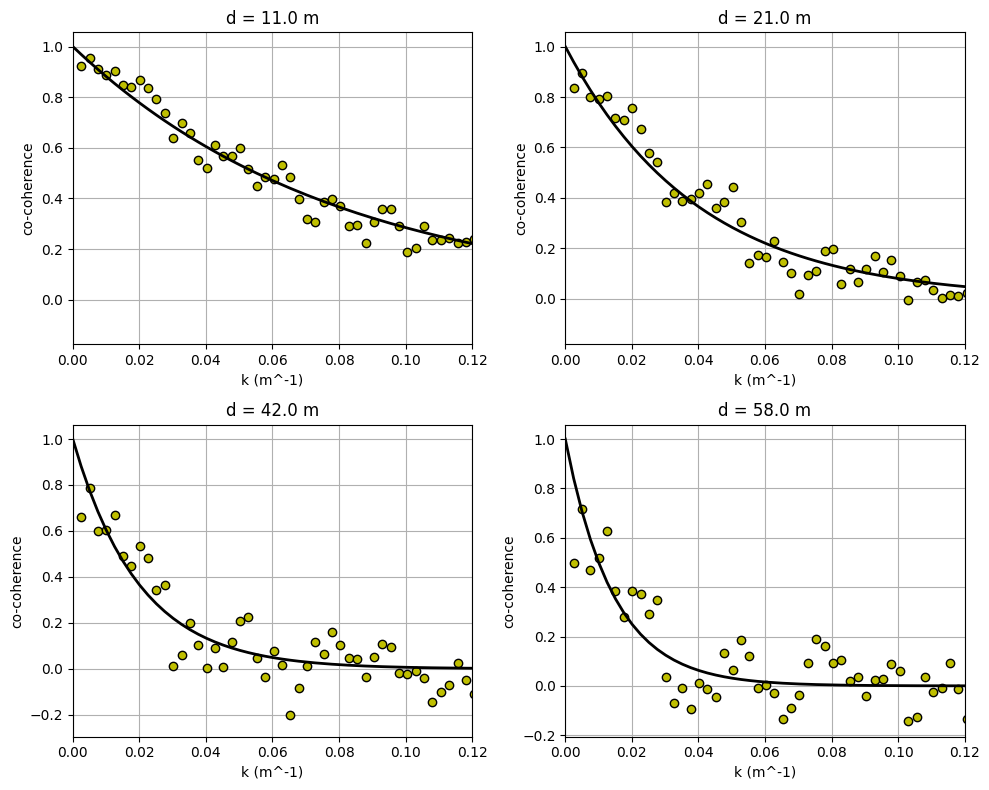

In [70]:
k = 2 * np.pi * freq / 20

print(freq.shape)
print(meanCoCoh[0, :].reshape((meanCoCoh.shape[1],)).shape)


fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for ii, target in enumerate(distTarget, 1):
    indDist = []
    ind = np.argmin(np.abs(uniqueDist - target))
    indDist.append(ind)
    ax = axs[(ii - 1) // 2, (ii - 1) % 2]
    ax.plot(k[1:], meanCoCoh[indDist, :].reshape((meanCoCoh.shape[1],)), 'ko', markerfacecolor='y')
    ax.plot(k[:], np.exp(-7.5 * y[0, ind] * freq / 20), 'k', linewidth=2)
    ax.set_title('d = {:.1f} m'.format(np.round(uniqueDist[ind])))
    ax.set_xlim([0, 0.12])
    ax.set_xlabel('k (m^-1)')
    ax.set_ylabel('co-coherence')
    ax.grid(True)

plt.tight_layout()
plt.show()